#### Load Movie reviews Dataset

We will be using data available on Kaggle platform for this exercise. The data is available at https://www.kaggle.com/c/word2vec-nlp-tutorial/data.

In [ ]:
# !pip install --force-reinstall --no-cache-dir numpy gensim


In [ ]:
#Connect Google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Load dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_path = '/content/drive/MyDrive/0.Latest_DS_Course/NLP/NoteBooks/data/labeledTrainData.tsv.zip'


In [ ]:
#change file path to point to where you have stored the zip file.
df = pd.read_csv(data_path, header=0, delimiter="\t", quoting=3)

In [ ]:
print('Number of examples in Dataset: ', df.shape)
df.head()

In [ ]:
df.shape

In [ ]:
df.loc[0, 'review']

Split Data into Training and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment'],
    test_size=0.2,
    random_state=42
)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_test[0:1], y_test[0:1]

In [ ]:
X_test[5:6], y_test[5:6]

#### Build the Tokenizer

In [ ]:
import tensorflow as tf

In [ ]:
desired_vocab_size = 10000 #Vocablury size
t = tf.keras.preprocessing.text.Tokenizer(num_words=desired_vocab_size) # num_words -> Vocablury size

In [ ]:
#Fit tokenizer with actual training data
t.fit_on_texts(X_train.tolist())

In [ ]:
#Vocabulary
t.word_index

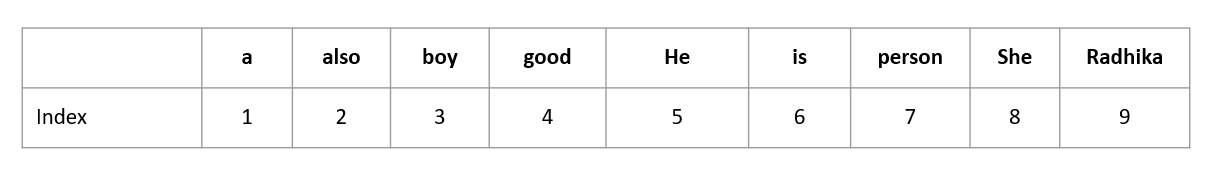

In [ ]:
len(t.word_index)

#### Prepare Training and Test Data

Get the word index for each of the word in the review

In [ ]:
X_train[0:1]

In [ ]:
X_train = t.texts_to_sequences(X_train.tolist())

In [ ]:
print(X_train[0:1])

In [ ]:
X_test = t.texts_to_sequences(X_test)

How many words in each review?

In [ ]:
len(X_train[200])

#### Pad Sequences - Important

In [ ]:
#Define maximum number of words to consider in each review
max_review_length = 300

In [ ]:

#Pad training and test reviews
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        maxlen=max_review_length,
                                                        padding='post',
                                                        truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       maxlen=max_review_length,
                                                       padding='post',truncating='post')

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train[200]

#### Load Glove model

We can use gensim library to load pre-trained Word2Vec or Glove models. For list of available models can be found at [this url](https://github.com/RaRe-Technologies/gensim-data).

In [ ]:
!pip install gensim --quiet

In [ ]:
import gensim.downloader as api

In [ ]:
#Load Glove model (similar to Word2Vec)
glove_model = api.load('glove-wiki-gigaword-50')

In [ ]:
#Model vocabulary
glove_model.index_to_key

In [ ]:
len(glove_model.index_to_key)

In [ ]:
#Size of the model
glove_model.vectors.shape

In [ ]:
#Embedding for word great
glove_model['and']

In [ ]:
glove_model.vector_size

#### Get Pre-trained Embeddings

Pre-trained Glove model has 400,000 unique words (Vocabulary size). We do not need all the words. Moreover, we have to arrange word embeddings according to word index created by our tokenizers above. So we will extract word embeddings for only the words that we are interested in.

In [ ]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = glove_model.vector_size

In [ ]:
embedding_vector_length

In [ ]:
desired_vocab_size

Initialize a embedding matrix which we will populate for our vocabulary words.

In [ ]:
#Initialize embedding matrix for our dataset with 10000+1 rows (1 for padding word)
#and 50 columns (as embedding size is 50)
embedding_matrix = np.zeros((desired_vocab_size + 1, embedding_vector_length))

In [ ]:
np.zeros((2,2))

In [ ]:
embedding_matrix.shape

In [ ]:
embedding_matrix

Load word vectors for each word in our vocabulary from from Glove pre-trained model

In [ ]:
for word, i in sorted(t.word_index.items(),key=lambda x:x[1]):
    if i > (desired_vocab_size+1):
        break
    try:
        embedding_vector = glove_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

We now have word embeddings for our vocabulary words from Glove model. We can now use it in our Model training.

In [ ]:
embedding_matrix[200]

#### Build Model - Dense Layers

In [ ]:
#Initialize model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

To handle, pre-trained embeddings, we will use Keras Embedding layer

In [ ]:
model.add(tf.keras.layers.Embedding(desired_vocab_size + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

Embedding Layer gives us 3D output ->
[Batch_Size , Review Length , Embedding_Size]

Add Hidden layers

In [ ]:
#Flatten the data as we will use Dense layers
model.add(tf.keras.layers.Flatten())

In [ ]:
#Add Hidden layers (Dense layers)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=()))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

Add Output layer

In [ ]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

##### Train Model

In [ ]:
model.fit(X_train,y_train,
          epochs=5,
          batch_size=32,
          validation_data=(X_test, y_test))

In [ ]:
model.summary()

#### Building a CNN Model

Start a model

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.Sequential()

Add Embedding layer to handle Word2Vec

In [ ]:
model2.add(tf.keras.layers.Embedding(desired_vocab_size + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

Add Conv1D hidden layers : As our text data is 2D (number of words, Embedding size), we will use Conv1D in this case (compared to Conv2D with images which are 3D)

In [ ]:
#Add first convolutional layer
model2.add(tf.keras.layers.Conv1D(32, #Number of filters
                                 kernel_size=(3), #Size of the filter
                                 strides=1,
                                 activation='relu'))

#normalize data
model2.add(tf.keras.layers.BatchNormalization())

#Add second convolutional layer
model2.add(tf.keras.layers.Conv1D(32, kernel_size=(3), strides=2))
model2.add(tf.keras.layers.ReLU())

#normalize data
model2.add(tf.keras.layers.BatchNormalization())

In [ ]:
#Use Global Average Pooling
model2.add(tf.keras.layers.GlobalAveragePooling1D())

# model2.output

In [ ]:
#Output layer
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the model
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model2.fit(X_train,y_train,
          epochs=5,

          batch_size=32,
          validation_data=(X_test, y_test))

In [ ]:
model2.summary()

In [ ]:
11000/1500000

### What if we want to train our own embedding

In [ ]:
tf.keras.backend.clear_session()
model3 = tf.keras.Sequential()

In [ ]:
model3.add(tf.keras.layers.Embedding(desired_vocab_size + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    #weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    #trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=max_review_length) #Number of words in each review
          )

In [ ]:
#Add first convolutional layer
model3.add(tf.keras.layers.Conv1D(32, #Number of filters
                                 kernel_size=(3), #Size of the filter
                                 strides=1,
                                 activation='relu'))

#normalize data
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.25))

#Add second convolutional layer
model3.add(tf.keras.layers.Conv1D(64, kernel_size=(3), strides=2))
model3.add(tf.keras.layers.ReLU())
#normalize data
model3.add(tf.keras.layers.BatchNormalization())

In [ ]:
#Use Global Average Pooling
model3.add(tf.keras.layers.GlobalAveragePooling1D())
model3.add(tf.keras.layers.Dropout(0.25))
# model3.output

In [ ]:
#Output layer
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the model
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model3.fit(X_train,y_train,
          epochs=5,
          batch_size=32,
          validation_data=(X_test, y_test))

In [ ]:
model3.summary()

In [ ]:
X_test[0:1]

In [ ]:
pred3 = model3.predict(X_test[0:1])

In [ ]:
X_test[0]

In [ ]:
pred3

In [ ]:
sent =-1;

if pred3>0.5 :
  sent=1
else:
  sent=0

print(sent)

In [ ]:
y_test[0:1]

In [ ]:

def model_pred(n):
  print("Predicted : ", int(model3.predict(X_test[n:n+1])>0.5),"   Actual: ", y_test[n:n+1].values)

In [ ]:
model_pred(6)

In [ ]:
model.predict(X_test[5:6]), y_test[5:6]

In [ ]:
model2.predict(X_test[5:6]), y_test[5:6]

In [ ]:
X_test[5:6]

In [ ]:
y_test[5:6]

In [ ]:
df.loc[7488]

In [ ]:
X_test[0:1]

In [ ]:
y_test[0:1]

In [ ]:
df.loc[6868]

In [ ]:
model.predict(X_test[5:6]), y_test[5:6]

In [ ]:
X_test[8:9], y_test[8:9]

In [ ]:
model3.predict(X_test[8:9])

In [ ]:
model2.predict(X_test[8:9])

In [ ]:
model.predict(X_test[8:9])

In [ ]:
X_test[0:1]

In [ ]:
y_test[0:1]

In [ ]:
convert_pred(model3.predict(X_test[7:8]), y_test[7:8] )

In [ ]:
def convert_pred(val, exp):
  pred = -1
  if val<0.5:
    pred= 0
  else:
    pred= 1

  if int(pred)==int(exp):
    return "correct prediction"
  else:
    return "wrong prediction"